# Time evolution of harmonic oscillator states in real space
This computational notebook provides the tools to prepare harmonic oscillator states in one dimensional space. One can then shift the position of these states or excite them with a given momentum, to observed the real-time dynamics of the states. This is useful for a variety of aspects, but particularly for coherent states. 

## Split operator method
This notebook solves the dynamics of the Harmonic Oscillator (HO) in a 1D grid in space. This is set-up as a vector of $N_x=100$ points from $x=-6$ to $x=+6$ in HO units. The time evolution is obtained using the Split-Operator Method. Here, one splits the HO hamiltonian $\hat H=\hat K + \hat U$ into kinetic $\hat K = \frac{\hat p^2}{2}$ and potential $\hat U = \frac{\hat x^2}{2}$ terms. The time evolution operator is formally written as $\hat U(\delta t)=e^{-i \hat H \delta t}$. One can also define time evolution operators for the split parts of the hamiltonian, so that $\hat U_p(\delta t)=e^{-i \hat K \delta t}$ is diagonal in momentum space and associated to the kinetic energy, and $\hat U_x(\delta t)=e^{-i \hat U \delta t}$ is diagonal in real space and linked to the potential energy.

The time evolution starts with an eigenstate of the Harmonic Oscillator in real space, $\psi_n(x,t=0)$. One would like to apply the full operator $\hat U(\delta t)$ on this wave function, but this is not straightforward because $\hat K$ cannot be easily expressed in real space. The Split Operator Method consists in using the replacement
$$ \hat U(\delta t) \approx \hat U_x(\delta t/2) \hat U_p(\delta t) \hat U_x(\delta t/2)$$
which is valid for sufficiently small $\delta t$. Note that now each term is independently diagonal in real or momentum space. For instance, the real space part consists simply in multiplying by a phase, 
$$ \hat U_x(\delta t/2) \psi_n(x,t) = e^{-i \frac{x \delta t}{4} }\psi_n(x,t). $$

To apply the operator in momentum space, one can transform the wave function into momentum space, 
$\psi_n(p,t) = FT \{ \psi_n(x,t) \}$. This can be done efficiently by performing a Fast Fourier Transform on the discrete grid of points in real space. This requires some careful manipulation of the indices in the grid in real and momentum space, which is discussed below. With the wavefunction in momentum space, the small time step in the momentum representation is again just a phase multiplication, $$ \hat U_p(\delta t) \psi_n(p,t) = e^{-i \frac{p}{2}\delta t}\psi_n(p,t=0). $$

## Code
### Real space grid
We start by loading the relevant python packages and generating a mesh in real space, which is stored in the xx vector. Note that this is slightly offset from the lower limit and goes through zero.

In [15]:
# coding: utf-8
##########################################################################
# THIS PYTHON CODE SOLVES THE HARMONIC OSCILLATOR IN REAL SPACE
# USING THE FOURIER GRID HAMILTONIAN METHOD
##########################################################################
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from tqdm import tqdm
from harmonic_oscillator import *

zi=complex(0,1);
pi=math.pi

# NUMBER OF EIGENSTATES TO CONSIDER
N_eigen=3;

# REAL-SPACE MESH DIMENSION AND NUMBER POINTS
xL=6.
Nx=100

# GRID SPACING
delx=2*xL/Nx

# MESH IN X-SPACE - FROM -xL+del x UP TO +xL
xx=np.zeros(Nx)
xx=delx*(np.arange(Nx)-Nx/2.+1)
print(xx)
indelx_origin=int(Nx/2-1)


[-5.88 -5.76 -5.64 -5.52 -5.4  -5.28 -5.16 -5.04 -4.92 -4.8  -4.68 -4.56
 -4.44 -4.32 -4.2  -4.08 -3.96 -3.84 -3.72 -3.6  -3.48 -3.36 -3.24 -3.12
 -3.   -2.88 -2.76 -2.64 -2.52 -2.4  -2.28 -2.16 -2.04 -1.92 -1.8  -1.68
 -1.56 -1.44 -1.32 -1.2  -1.08 -0.96 -0.84 -0.72 -0.6  -0.48 -0.36 -0.24
 -0.12  0.    0.12  0.24  0.36  0.48  0.6   0.72  0.84  0.96  1.08  1.2
  1.32  1.44  1.56  1.68  1.8   1.92  2.04  2.16  2.28  2.4   2.52  2.64
  2.76  2.88  3.    3.12  3.24  3.36  3.48  3.6   3.72  3.84  3.96  4.08
  4.2   4.32  4.44  4.56  4.68  4.8   4.92  5.04  5.16  5.28  5.4   5.52
  5.64  5.76  5.88  6.  ]


### Momentum space grid
We generate a momentum space grid. The choice of momenta is entirely dictated by the use of the Fast Fourier Transform algorithm and the transition from a continuous to a discrete Fourier transform.

In [16]:
# SPACING IN MOMENTUM SPACE
delp=2.*pi/(2.*xL)

# MESH IN MOMENTUM SPACE
pp=np.zeros(Nx)
for i in range(0,Nx) :
    pp[i]=(i-Nx/2)*delp
pp2=np.power(pp,2)

### Initial wavefunctions
We set up a number of $N_\text{eigen}$ eigenvalues of the harmonic oscillator. The <harmonic_oscillator.py> routine in this folder generates these from the standard formula. The eigenvalues are set, and these are plotted for convenience.

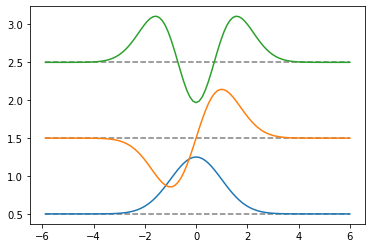

In [17]:
# RENORMALIZE WAVEFUNCTIONS, COMUPTE NORMS FOR CROSS-CHECK AND PLOT
phi=np.zeros([Nx,N_eigen],dtype=complex);
norm=np.zeros(N_eigen);
ener=np.zeros(N_eigen);
for n in range(N_eigen) :
    phi[:,n] = wfho(n,xx)
    norm[n]=np.real( np.sum( np.conj(phi[:,n])*phi[:,n] )*delx )
    ener[n]=n+0.5

    #plot wavefunction as a function of position
    plt.plot(xx,ener[n]*np.ones(Nx),'--',color='grey');
    plt.plot(xx,ener[n]+phi[:,n],'-');

### Time evolution: initial conditioms
Here, we set up the initial condition for the time evolution. The eigenstates are shifted by $p_0$ ($x_0$) units in momentum (real) space. We also set up the vectors that are necessary for the FFT. 

In [18]:
# The initial wave function is shifted by p_0 units in momentum space, and x_0 units in real space.
p0=1.0
x0=0.0

# ... 0 - Nx-1 -> Range needed in the Fourier transform -> Given by iNx
iNx=np.zeros(Nx)
ii=np.arange(1,Nx/2+1,1)

phift=np.zeros(Nx)
ppift=np.zeros([Nx,N_eigen],dtype=complex);
for nn in range(N_eigen) :
    phift=phi[:,nn]
    # SHIFT IN MOMENTUM SPACE
    phift=np.exp( zi*p0*xx )*phift
    # FOURIER TRANSFORM
    ppp=np.exp(-zi*pi*np.arange(Nx))*fft( np.exp(-zi*pi*np.arange(Nx))*phift )
    # SHIFT IN POSITION SPACE
    ppp_shift=np.exp(-zi*x0*pp)*ppp
    # INVERSE FOURIER TRANSFORM
    ppift[:,nn]=np.exp(+zi*pi*np.arange(Nx))*ifft( np.exp(+zi*pi*np.arange(Nx))*ppp_shift )

### Time evolution
Here, the time evolution is performed for $N_t$ in steps of $\delta t = dt$. This is performed for one specific eigenvalue $n_\text{dyn}$. 

Loading...:   0%|                                                                                                           | 0/100 [00:00<?, ?it/s]

0


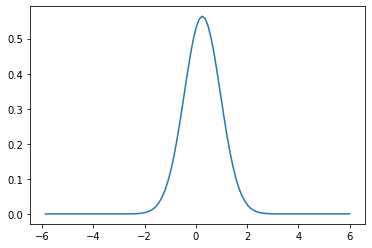

1


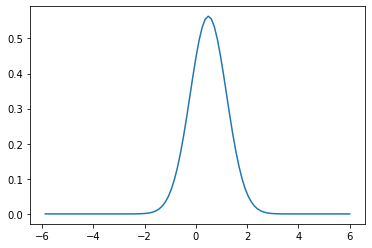

Loading...:   2%|█▉                                                                                                 | 2/100 [00:00<00:09, 10.76it/s]

2


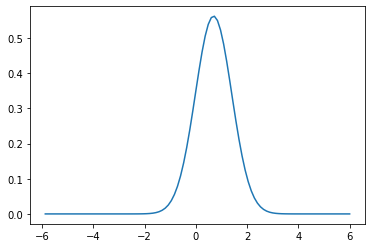

3


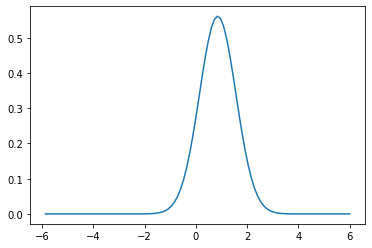

Loading...:   4%|███▉                                                                                               | 4/100 [00:00<00:06, 14.25it/s]

4


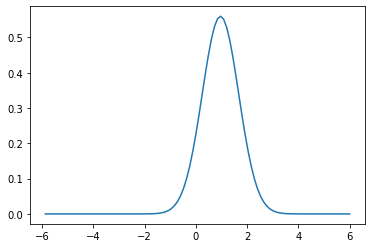

5


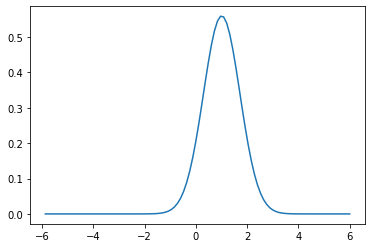

Loading...:   6%|█████▉                                                                                             | 6/100 [00:00<00:05, 15.83it/s]

6


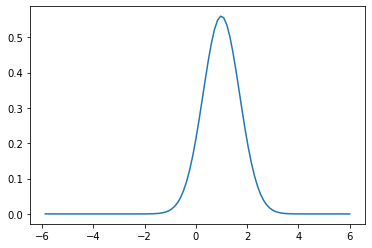

7


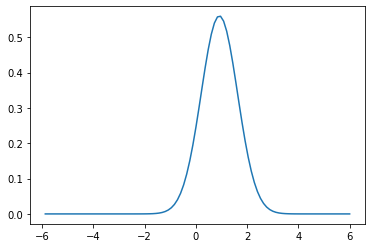

Loading...:   8%|███████▉                                                                                           | 8/100 [00:00<00:05, 16.56it/s]

8


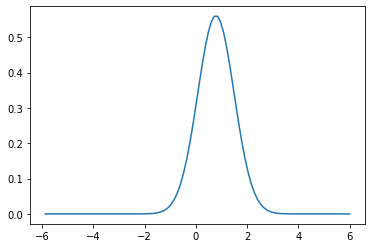

9


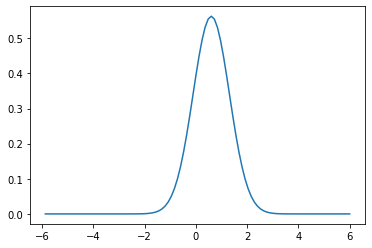

Loading...:  10%|█████████▊                                                                                        | 10/100 [00:00<00:05, 17.19it/s]

10


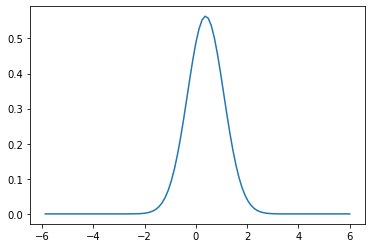

11


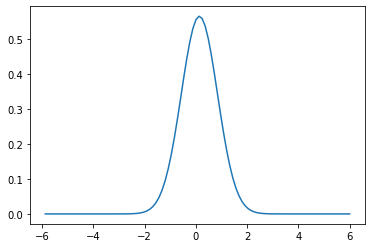

Loading...:  12%|███████████▊                                                                                      | 12/100 [00:00<00:04, 17.61it/s]

12


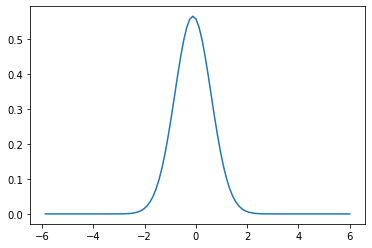

13


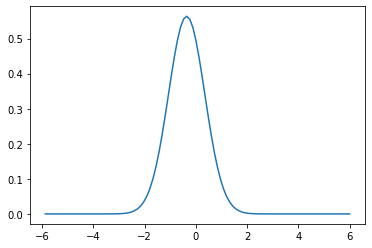

Loading...:  14%|█████████████▋                                                                                    | 14/100 [00:00<00:04, 17.94it/s]

14


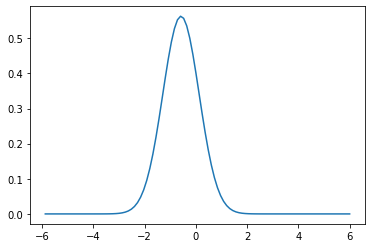

15


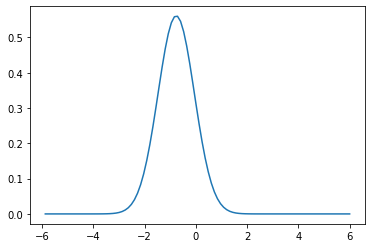

Loading...:  16%|███████████████▋                                                                                  | 16/100 [00:00<00:05, 16.54it/s]

16


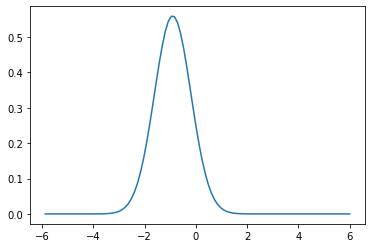

17


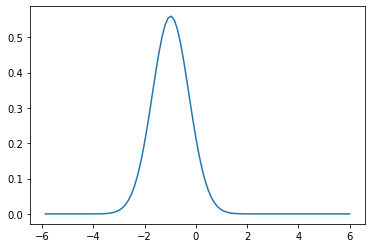

Loading...:  18%|█████████████████▋                                                                                | 18/100 [00:01<00:04, 17.00it/s]

18


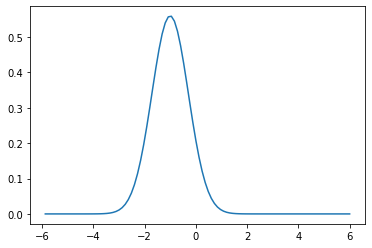

19


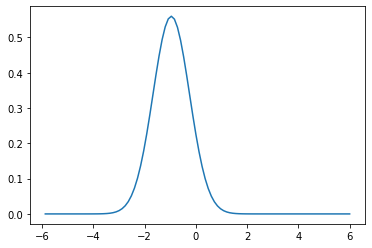

Loading...:  20%|███████████████████▌                                                                              | 20/100 [00:01<00:04, 17.47it/s]

20


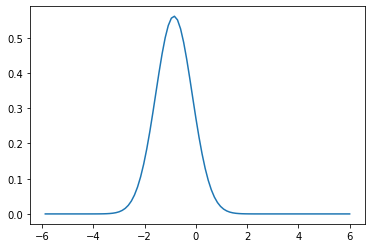

21


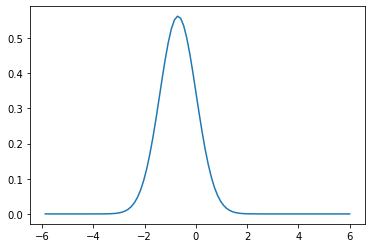

Loading...:  22%|█████████████████████▌                                                                            | 22/100 [00:01<00:04, 17.57it/s]

22


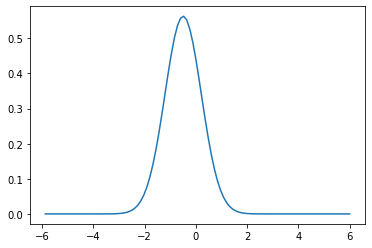

23


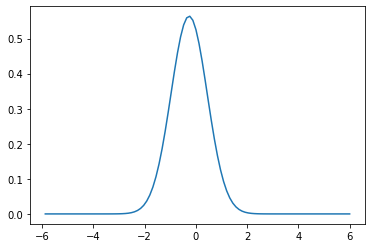

Loading...:  24%|███████████████████████▌                                                                          | 24/100 [00:01<00:04, 17.76it/s]

24


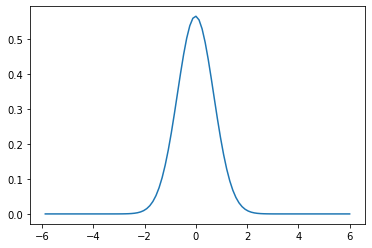

25


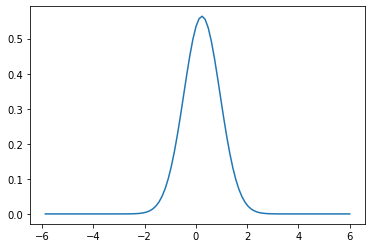

Loading...:  26%|█████████████████████████▍                                                                        | 26/100 [00:01<00:04, 17.78it/s]

26


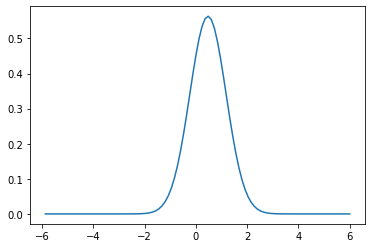

27


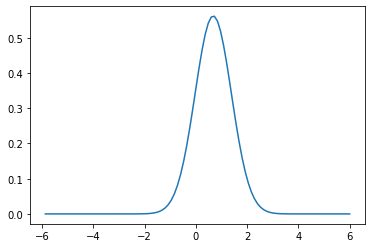

Loading...:  28%|███████████████████████████▍                                                                      | 28/100 [00:01<00:04, 17.85it/s]

28


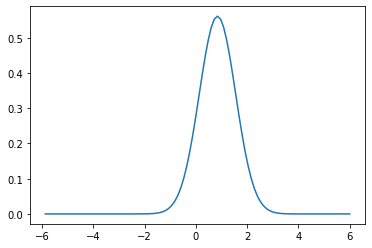

29


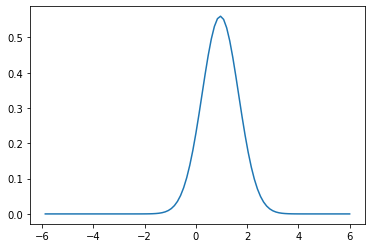

Loading...:  30%|█████████████████████████████▍                                                                    | 30/100 [00:01<00:04, 16.47it/s]

30


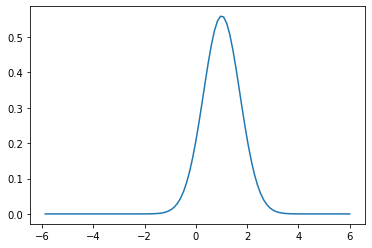

31


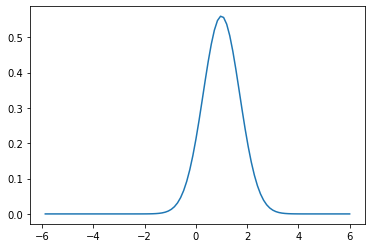

Loading...:  32%|███████████████████████████████▎                                                                  | 32/100 [00:01<00:03, 17.01it/s]

32


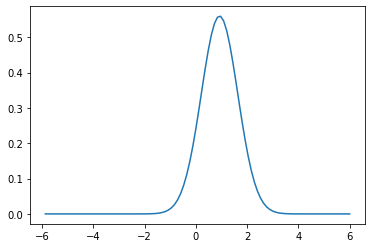

33


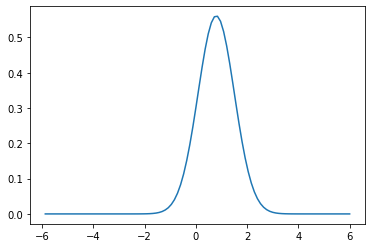

Loading...:  34%|█████████████████████████████████▎                                                                | 34/100 [00:02<00:03, 17.47it/s]

34


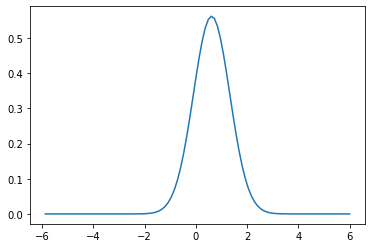

35


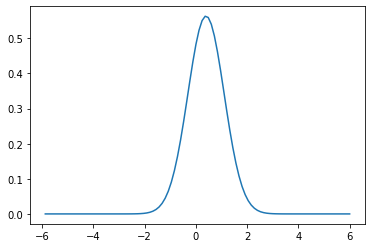

Loading...:  36%|███████████████████████████████████▎                                                              | 36/100 [00:02<00:03, 17.63it/s]

36


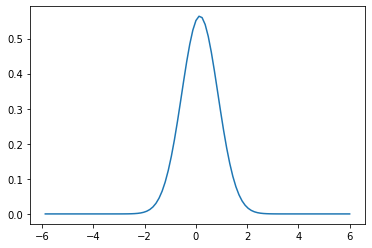

37


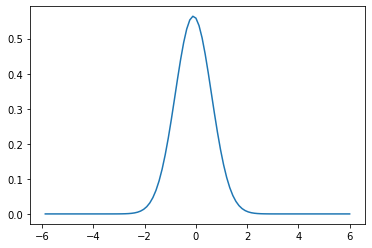

Loading...:  38%|█████████████████████████████████████▏                                                            | 38/100 [00:02<00:03, 17.58it/s]

38


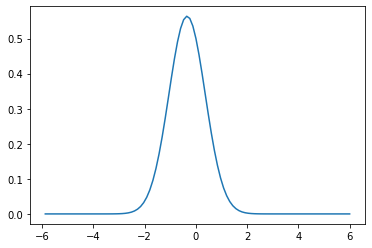

39


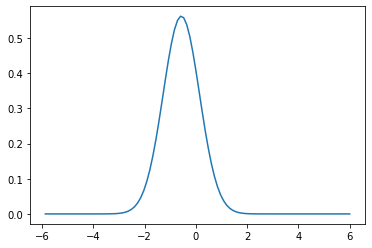

Loading...:  40%|███████████████████████████████████████▏                                                          | 40/100 [00:02<00:03, 17.61it/s]

40


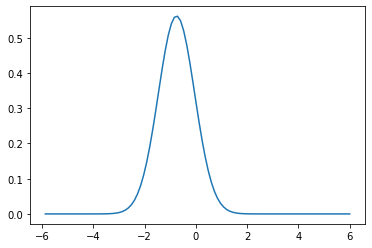

41


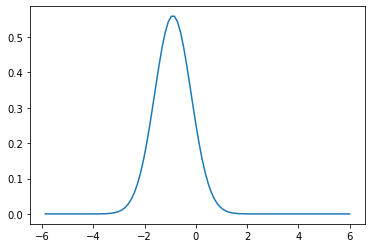

Loading...:  42%|█████████████████████████████████████████▏                                                        | 42/100 [00:02<00:03, 17.39it/s]

42


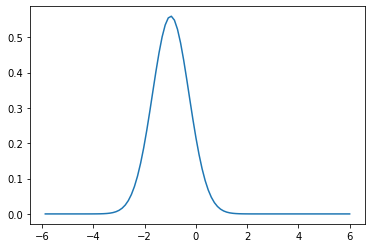

43


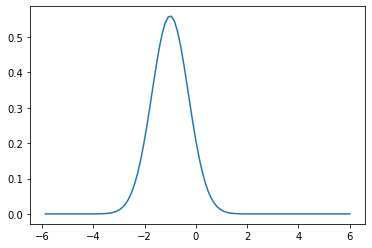

Loading...:  44%|███████████████████████████████████████████                                                       | 44/100 [00:02<00:03, 15.98it/s]

44


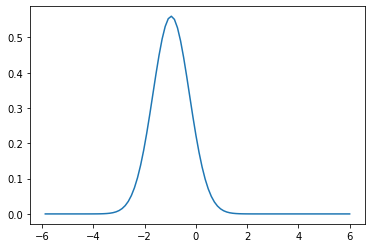

45


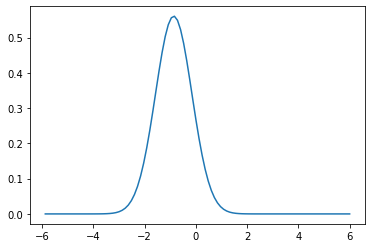

Loading...:  46%|█████████████████████████████████████████████                                                     | 46/100 [00:02<00:03, 16.54it/s]

46


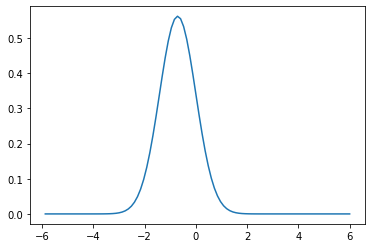

47


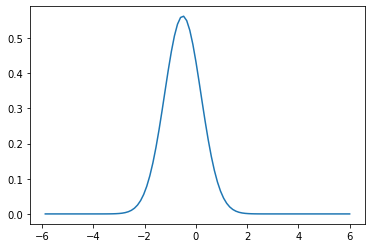

Loading...:  48%|███████████████████████████████████████████████                                                   | 48/100 [00:02<00:03, 16.53it/s]

48


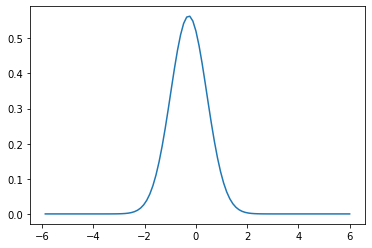

49


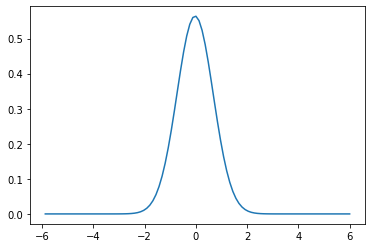

Loading...:  50%|█████████████████████████████████████████████████                                                 | 50/100 [00:02<00:02, 16.71it/s]

50


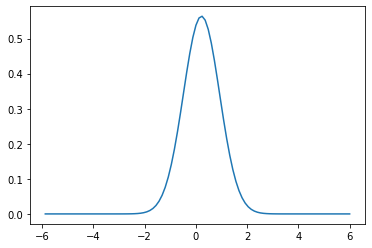

51


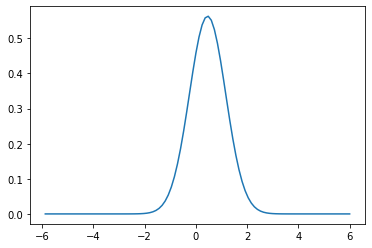

Loading...:  52%|██████████████████████████████████████████████████▉                                               | 52/100 [00:03<00:02, 16.78it/s]

52


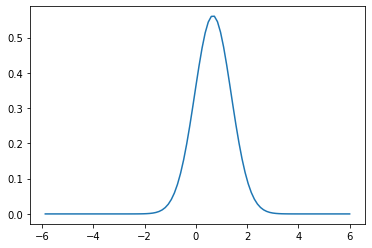

53


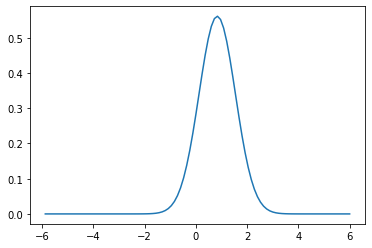

Loading...:  54%|████████████████████████████████████████████████████▉                                             | 54/100 [00:03<00:02, 16.87it/s]

54


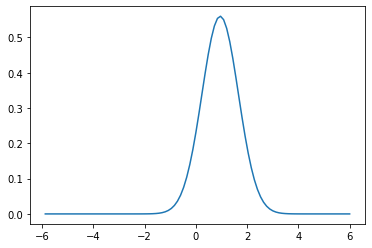

55


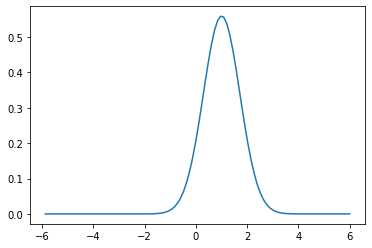

Loading...:  56%|██████████████████████████████████████████████████████▉                                           | 56/100 [00:03<00:02, 17.00it/s]

56


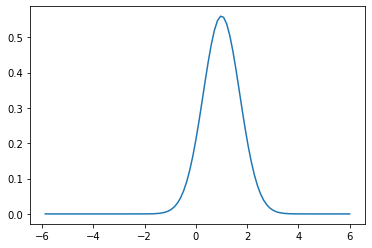

57


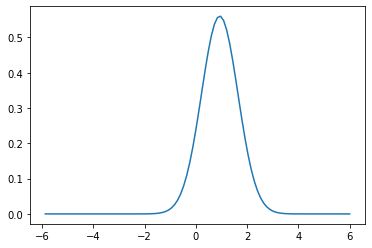

Loading...:  58%|████████████████████████████████████████████████████████▊                                         | 58/100 [00:03<00:02, 15.68it/s]

58


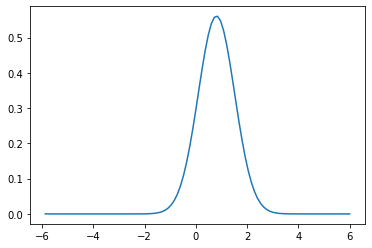

59


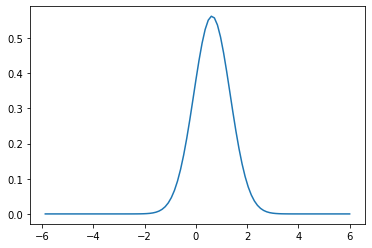

Loading...:  60%|██████████████████████████████████████████████████████████▊                                       | 60/100 [00:03<00:02, 16.36it/s]

60


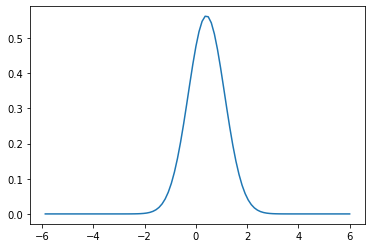

61


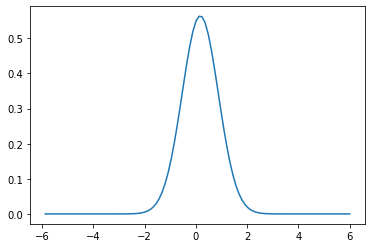

Loading...:  62%|████████████████████████████████████████████████████████████▊                                     | 62/100 [00:03<00:02, 16.62it/s]

62


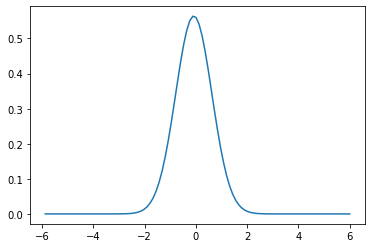

63


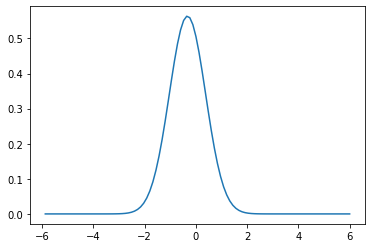

Loading...:  64%|██████████████████████████████████████████████████████████████▋                                   | 64/100 [00:03<00:02, 16.86it/s]

64


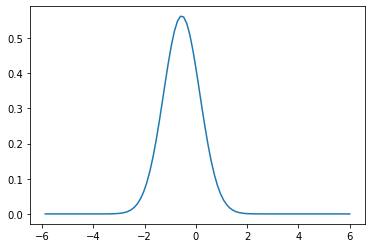

65


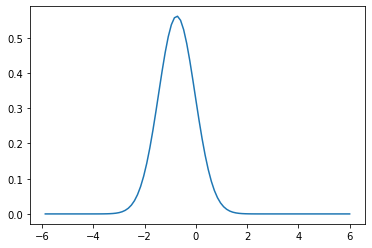

Loading...:  66%|████████████████████████████████████████████████████████████████▋                                 | 66/100 [00:03<00:02, 16.98it/s]

66


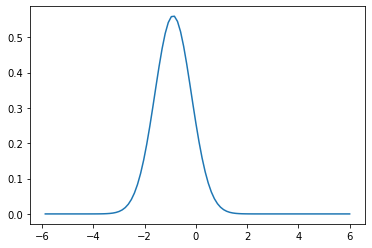

67


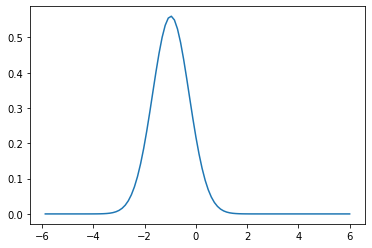

Loading...:  68%|██████████████████████████████████████████████████████████████████▋                               | 68/100 [00:04<00:01, 17.17it/s]

68


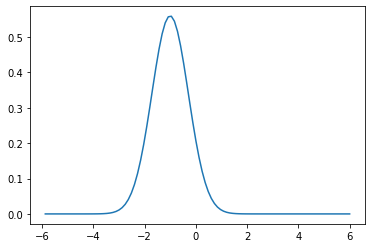

69


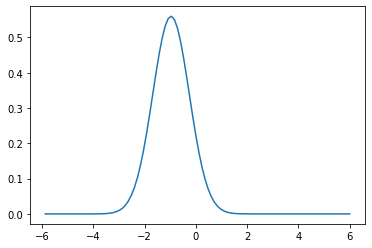

Loading...:  70%|████████████████████████████████████████████████████████████████████▌                             | 70/100 [00:04<00:01, 17.20it/s]

70


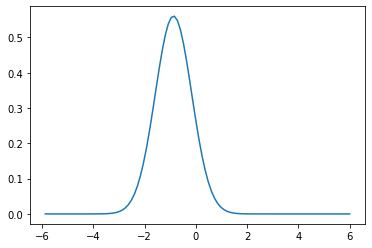

71


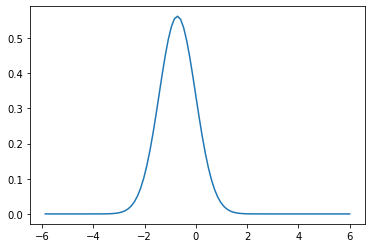

Loading...:  72%|██████████████████████████████████████████████████████████████████████▌                           | 72/100 [00:04<00:01, 15.70it/s]

72


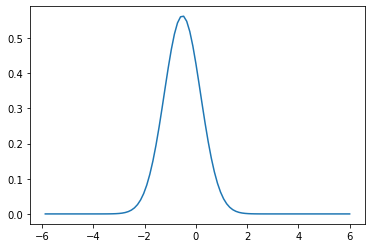

73


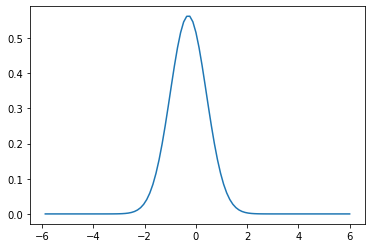

Loading...:  74%|████████████████████████████████████████████████████████████████████████▌                         | 74/100 [00:04<00:01, 16.26it/s]

74


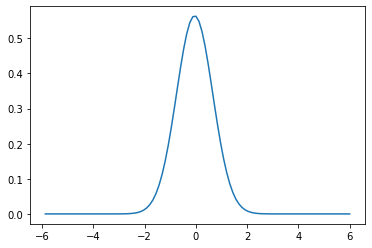

75


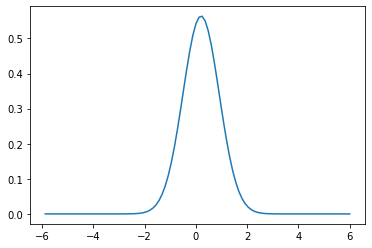

Loading...:  76%|██████████████████████████████████████████████████████████████████████████▍                       | 76/100 [00:04<00:01, 16.71it/s]

76


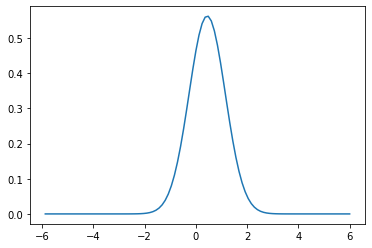

77


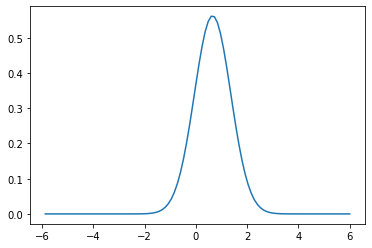

Loading...:  78%|████████████████████████████████████████████████████████████████████████████▍                     | 78/100 [00:04<00:01, 17.05it/s]

78


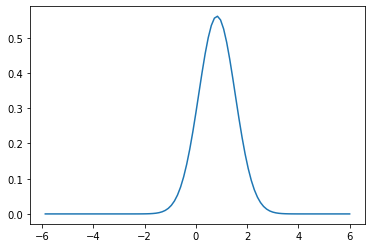

79


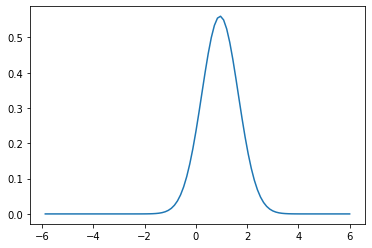

Loading...:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 80/100 [00:04<00:01, 17.10it/s]

80


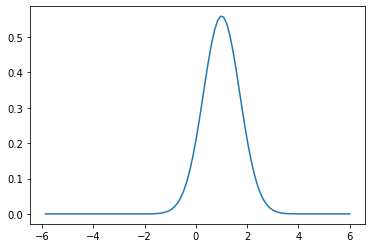

81


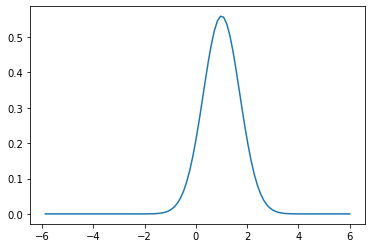

Loading...:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 82/100 [00:04<00:01, 17.09it/s]

82


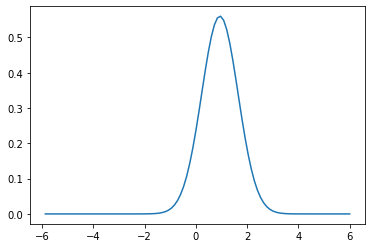

83


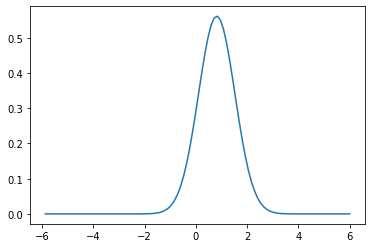

Loading...:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 84/100 [00:04<00:00, 17.22it/s]

84


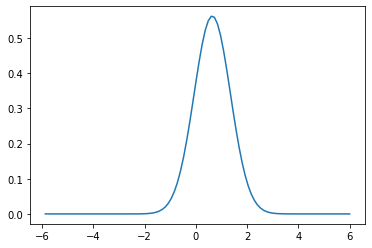

85


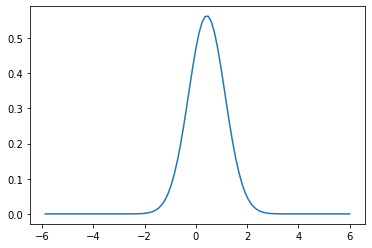

Loading...:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 86/100 [00:05<00:00, 15.99it/s]

86


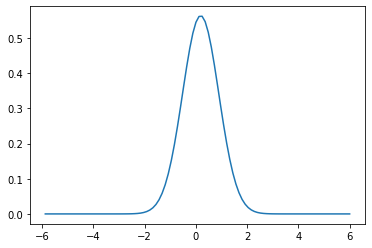

87


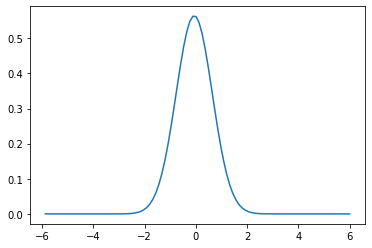

Loading...:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 88/100 [00:05<00:00, 16.58it/s]

88


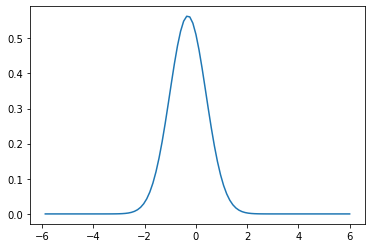

89


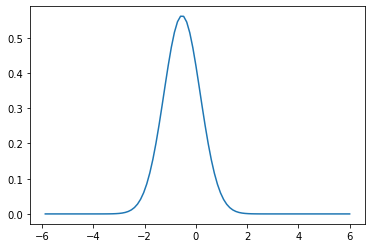

Loading...:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 90/100 [00:05<00:00, 16.81it/s]

90


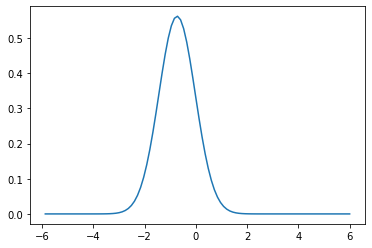

91


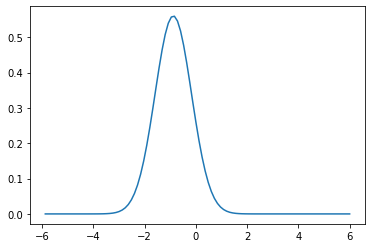

Loading...:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 92/100 [00:05<00:00, 16.75it/s]

92


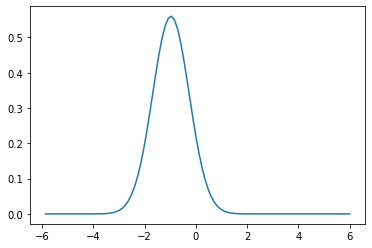

93


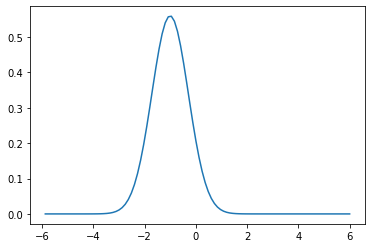

Loading...:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 94/100 [00:05<00:00, 16.81it/s]

94


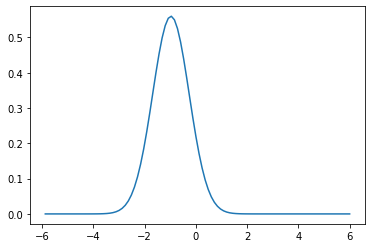

95


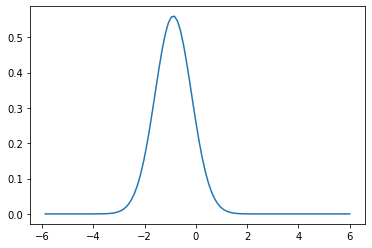

Loading...:  96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 96/100 [00:05<00:00, 17.01it/s]

96


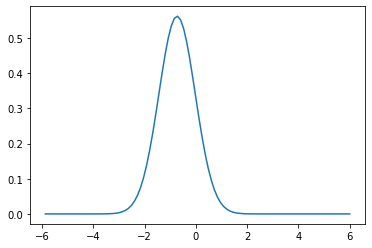

97


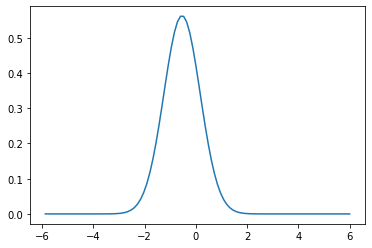

Loading...:  98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:05<00:00, 17.05it/s]

98


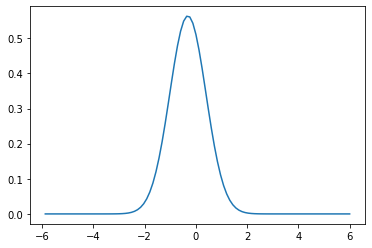

99


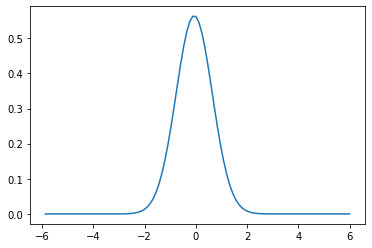

Loading...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.75it/s]


In [22]:
# START DYNAMICS
Nt=100
dt=0.25
nn_dyn=0
wfx0=ppift[:,nn_dyn]
x2=np.power(xx,2)
for it in tqdm(range (Nt), desc="Loading..."):
    print(it)
    # HALF STEP IN REAL SPACE REPRESENTATION
    wfx1=np.exp(-zi*dt*x2/4)*wfx0
    # FOURIER TRANSFORM
    wfp0=np.exp(-zi*pi*np.arange(Nx))*fft( np.exp(-zi*pi*np.arange(Nx))*wfx1 )
    # ONE STEP IN MOMENTUM SPACE (FACTOR OF 2??)
    wfp1=np.exp(-zi*dt/2*pp2)*wfp0
    # INVERSE FOURIER TRANSFORM
    wfx2=np.exp(+zi*pi*np.arange(Nx))*ifft( np.exp(+zi*pi*np.arange(Nx))*wfp1 )
    # HALF STEP IN REAL SPACE REPRESENTATION
    wfx3=np.exp(-zi*dt*x2/4)*wfx2

    wfx0=wfx3
    plt.plot(xx,np.conj(wfx0)*wfx0)
    plt.savefig("anim1/fig" + str(it).rjust(4,'0') + ".png",transparent=False)
#    plt.cla()
    plt.show()
